## Data import

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
clean_data_path = 'datasets/sube_transactions_cleaned.csv'


df_analisis = pd.read_csv(
    clean_data_path,
    parse_dates=['DIA_TRANSPORTE']
)

## Geographical Demand Analysis: Provinces

The goal is to visualize where the highest average daily usage occurs for the main transport types: 'COLECTIVO', 'TREN', and 'SUBTE'. We will group the data by PROVINCIA and TIPO_TRANSPORTE.

Pivot Table: Average Daily Usage by Province Category
TIPO_TRANSPORTE           COLECTIVO         SUBTE         TREN
PROVINCIA_CAT                                                 
Buenos Aires Province  11972.087753           NaN          NaN
CABA                   23246.806941  70164.559927  46707.42815
Other Provinces         2375.762961           NaN   1579.50000


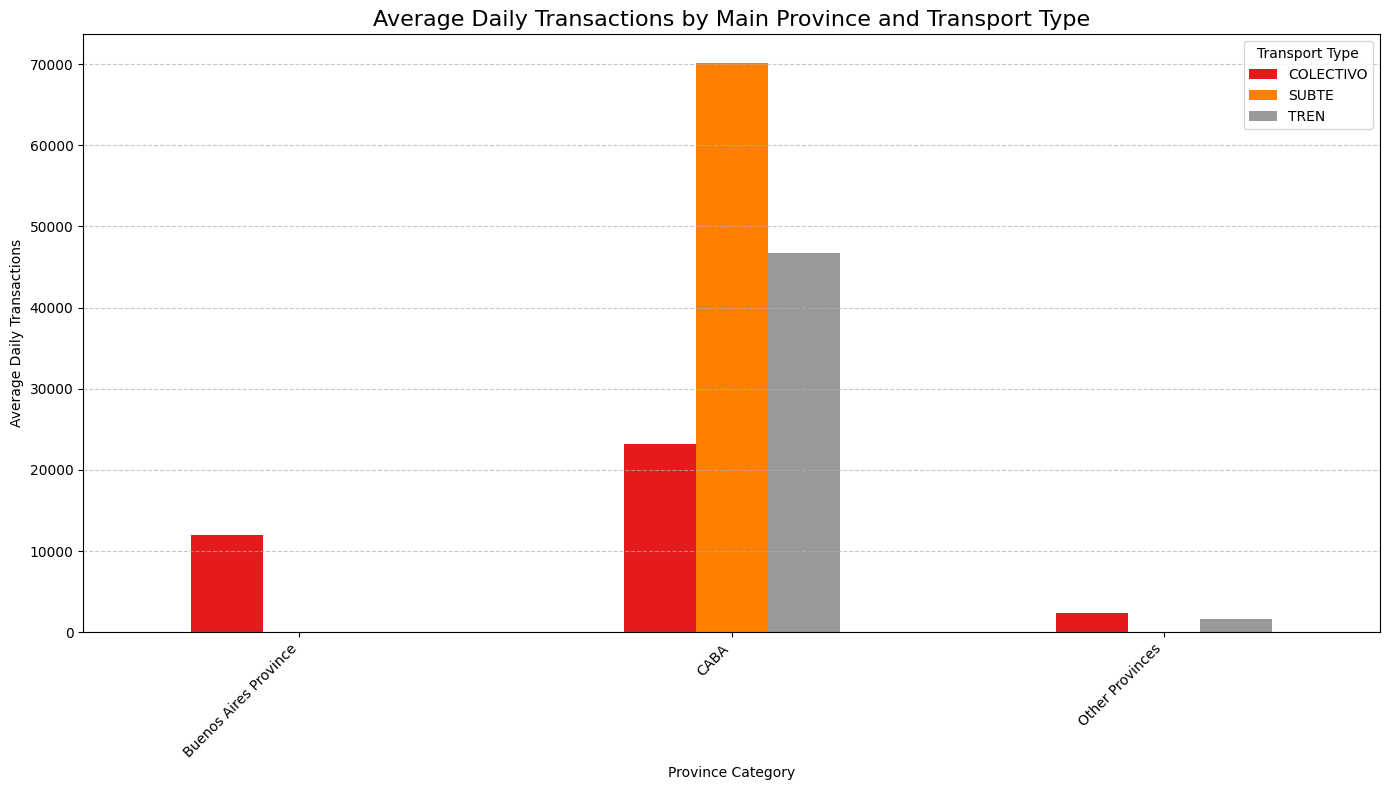

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the list of main transport types to analyze
MAIN_TRANSPORT_TYPES = ['COLECTIVO', 'TREN', 'SUBTE']

# 1. Standardize and categorize the provinces for plotting clarity
def categorize_province(province):
    """Categorizes provinces into main regions for clear analysis."""
    if province == 'BUENOS AIRES':
        return 'Buenos Aires Province'
    elif province == 'CABA':
        return 'CABA'
    elif province == 'JN':
        return 'CABA' # High volume, likely AMBA related
    else:
        return 'Other Provinces'

# Copy into a new dataframe
df_geo = df_analisis

# Create the categorized column
df_geo['PROVINCIA_CAT'] = df_geo['PROVINCIA'].apply(categorize_province)

# Filter for the main transport types
df_filtered = df_geo[df_geo['TIPO_TRANSPORTE'].isin(MAIN_TRANSPORT_TYPES)].copy()

# 2. Calculate the average daily usage grouped by Province Category and Transport Type
# We calculate the MEAN to smooth out daily variance and focus on typical demand.
df_geo_avg = df_filtered.groupby(
    ['PROVINCIA_CAT', 'TIPO_TRANSPORTE']
)['CANTIDAD'].mean().reset_index()

# 3. Create a pivot table for visualization
df_geo_pivot = df_geo_avg.pivot(
    index='PROVINCIA_CAT',
    columns='TIPO_TRANSPORTE',
    values='CANTIDAD'
)

print("Pivot Table: Average Daily Usage by Province Category")
print(df_geo_pivot)

# 4. Visualization: Grouped Bar Chart

# Set up the plot size
plt.figure(figsize=(14, 8))

# Create the grouped bar chart
df_geo_pivot.plot(kind='bar', ax=plt.gca(), cmap='Set1')

# Add titles and labels (in English)
plt.title('Average Daily Transactions by Main Province and Transport Type', fontsize=16)
plt.xlabel('Province Category')
plt.ylabel('Average Daily Transactions')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.legend(title='Transport Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() # Display the plot.

## Deep Dive into CABA (+AMBA)

To address the Capacity and Efficiency question in this high-demand zone, the next logical step is to identify the specific lines that are driving this massive average usage. These are the "bottlenecks" or areas requiring priority attention.

We will filter the data for the consolidated 'CABA' category and rank the top lines by their average daily transaction volume ($\text{CANTIDAD}$).

--- Top 10 Busiest Transport Lines in CABA (by Average Daily Usage) ---
                   LINEA TIPO_TRANSPORTE       CANTIDAD
116            FFCC ROCA            TREN  314167.258602
117             FFCC SAR            TREN  177035.750139
202              LINEA_B           SUBTE  119901.049866
191        LINEA SUBTE D           SUBTE  102840.846616
201              LINEA_A           SUBTE  100362.868562
27        BSAS_LINEA_060       COLECTIVO   85877.162042
190        LINEA SUBTE C           SUBTE   75740.665593
132            FFCC_SANM            TREN   74770.185350
122  FFCC_BELGRANO_NORTE            TREN   70039.537181
143             LINEA 28       COLECTIVO   64051.133740


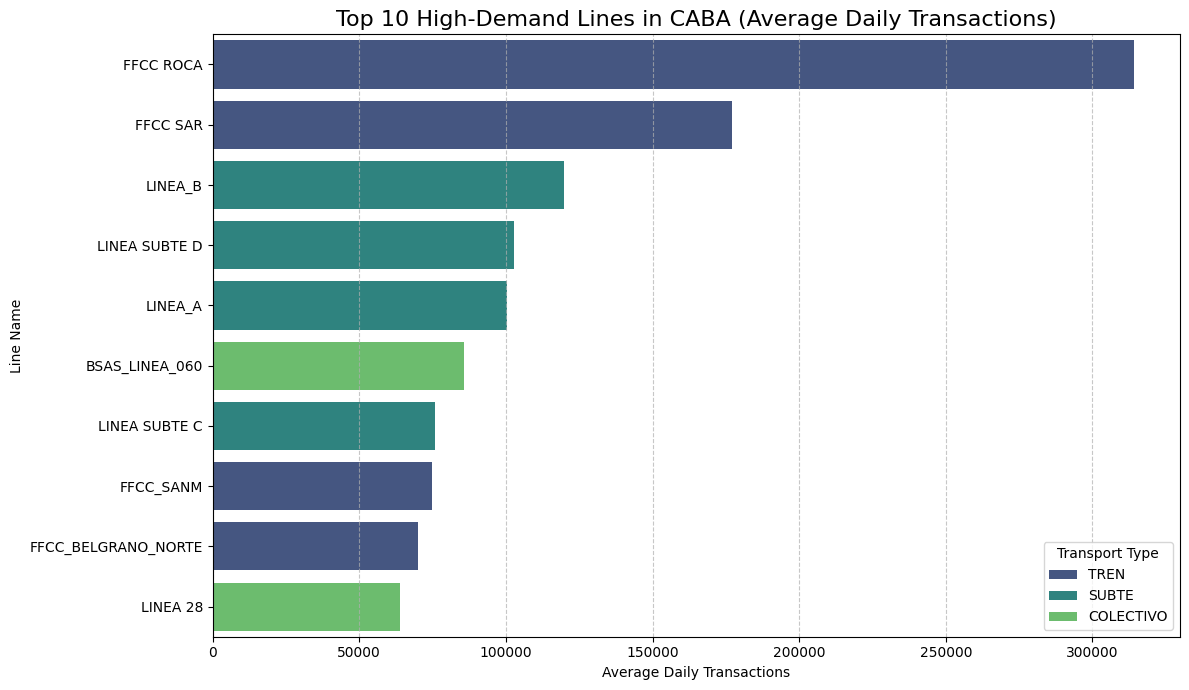

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the category name used for CABA
CABA_CATEGORY = 'CABA'

# 1. Filter the DataFrame for the consolidated CABA category
df_caba = df_geo[df_geo['PROVINCIA_CAT'] == CABA_CATEGORY].copy()

# 2. Calculate the average usage (CANTIDAD) per LINEA and TIPO_TRANSPORTE within CABA
# This helps identify the busiest lines regardless of whether they are bus, train, or subte.
df_top_lines = df_caba.groupby(['LINEA', 'TIPO_TRANSPORTE'])['CANTIDAD'].mean().reset_index()

# 3. Sort the lines to find the top 10 busiest lines
df_top_10 = df_top_lines.sort_values(by='CANTIDAD', ascending=False).head(10)

print("--- Top 10 Busiest Transport Lines in CABA (by Average Daily Usage) ---")
print(df_top_10)

# 4. Visualization: Bar Chart of Top 10 Lines

plt.figure(figsize=(12, 7))

# Create a bar plot using Seaborn for better aesthetic and handling of categories
sns.barplot(
    data=df_top_10,
    x='CANTIDAD',
    y='LINEA',
    hue='TIPO_TRANSPORTE', # Color bars by transport type
    dodge=False, # Ensure the bars are plotted next to each other if lines share names (not applicable here, but good practice)
    palette='viridis'
)

# Add titles and labels
plt.title(f'Top 10 High-Demand Lines in {CABA_CATEGORY} (Average Daily Transactions)', fontsize=16)
plt.xlabel('Average Daily Transactions')
plt.ylabel('Line Name')
plt.legend(title='Transport Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() # Display the plot.

The CABA/AMBA transport system is heavily reliant on a few high-capacity rail and subway lines (Roca, Sar, Subte B). These lines are operating at volumes that suggest frequent saturation and overcrowding.

**Actionable Insight:** The FFCC ROCA line should be the top priority for any capacity studies (frequency analysis, unit availability, infrastructure reliability).

Pivot Table: Average Weekly Demand (Top 10 vs. Other Lines)
LINE_GROUP  Other Lines  Top 10 Busiest Lines
DIA_SEMANA                                   
Monday      7863.830018         132243.587236
Tuesday     8338.372150         142703.522676
Wednesday   8374.625003         142475.481467
Thursday    8380.192229         144627.828030
Friday      8281.309007         139410.680226
Saturday    5780.542102          79817.446536
Sunday      3382.707221          33407.628268


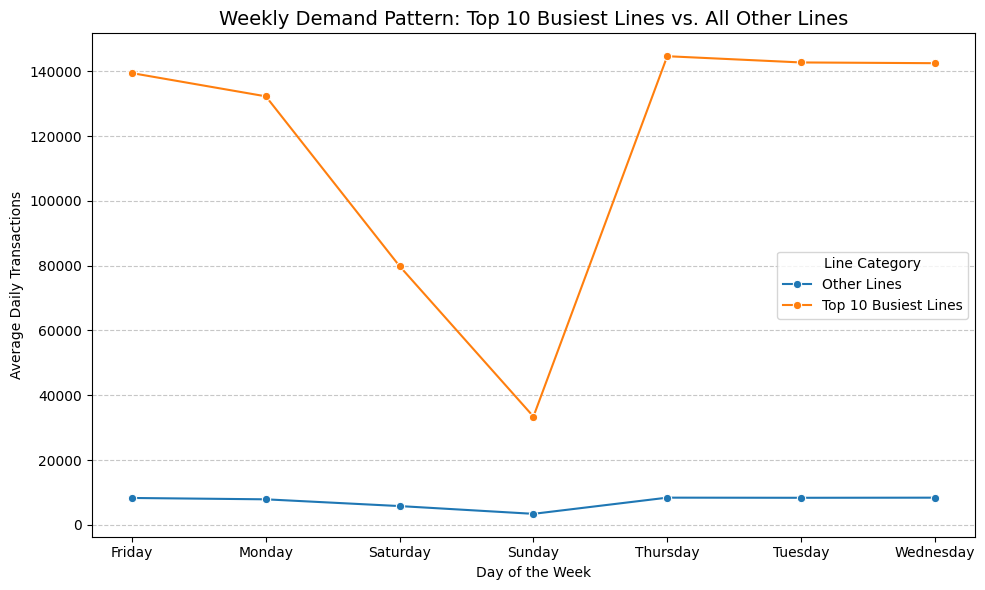

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the list of the top 10 lines identified previously
top_10_lines_list = df_top_10['LINEA'].tolist()

# 1. Create a boolean mask to categorize all lines into two groups: 'Top 10' or 'Other Lines'
df_geo['LINE_GROUP'] = df_geo['LINEA'].apply(
    lambda x: 'Top 10 Busiest Lines' if x in top_10_lines_list else 'Other Lines'
)

# 2. Define the correct order of the days of the week for plotting
day_order = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
    'Saturday', 'Sunday'
]

# 3. Calculate the average daily usage grouped by Day of the Week and the new Line Group
df_weekly_demand = df_geo.groupby(
    ['DIA_SEMANA', 'LINE_GROUP']
)['CANTIDAD'].mean().reset_index()

# 4. Create a pivot table for visualization
df_demand_pivot = df_weekly_demand.pivot(
    index='DIA_SEMANA',
    columns='LINE_GROUP',
    values='CANTIDAD'
).reindex(day_order)

print("Pivot Table: Average Weekly Demand (Top 10 vs. Other Lines)")
print(df_demand_pivot)

# 5. Visualization: Line Plot for Weekly Stress Comparison
plt.figure(figsize=(10, 6))

# Use a line plot to clearly show the drop-off trend
sns.lineplot(
    data=df_weekly_demand,
    x='DIA_SEMANA',
    y='CANTIDAD',
    hue='LINE_GROUP',
    marker='o',
    dashes=False,
    palette=['#1f77b4', '#ff7f0e'], # Blue for Top 10, Orange for Others
)

plt.title('Weekly Demand Pattern: Top 10 Busiest Lines vs. All Other Lines', fontsize=14)
plt.xlabel('Day of the Week')
plt.ylabel('Average Daily Transactions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Line Category')
plt.tight_layout()
plt.show() # Display the plot.

## Time-Series Analysis

Generating Year-by-Year Time-Series Plots


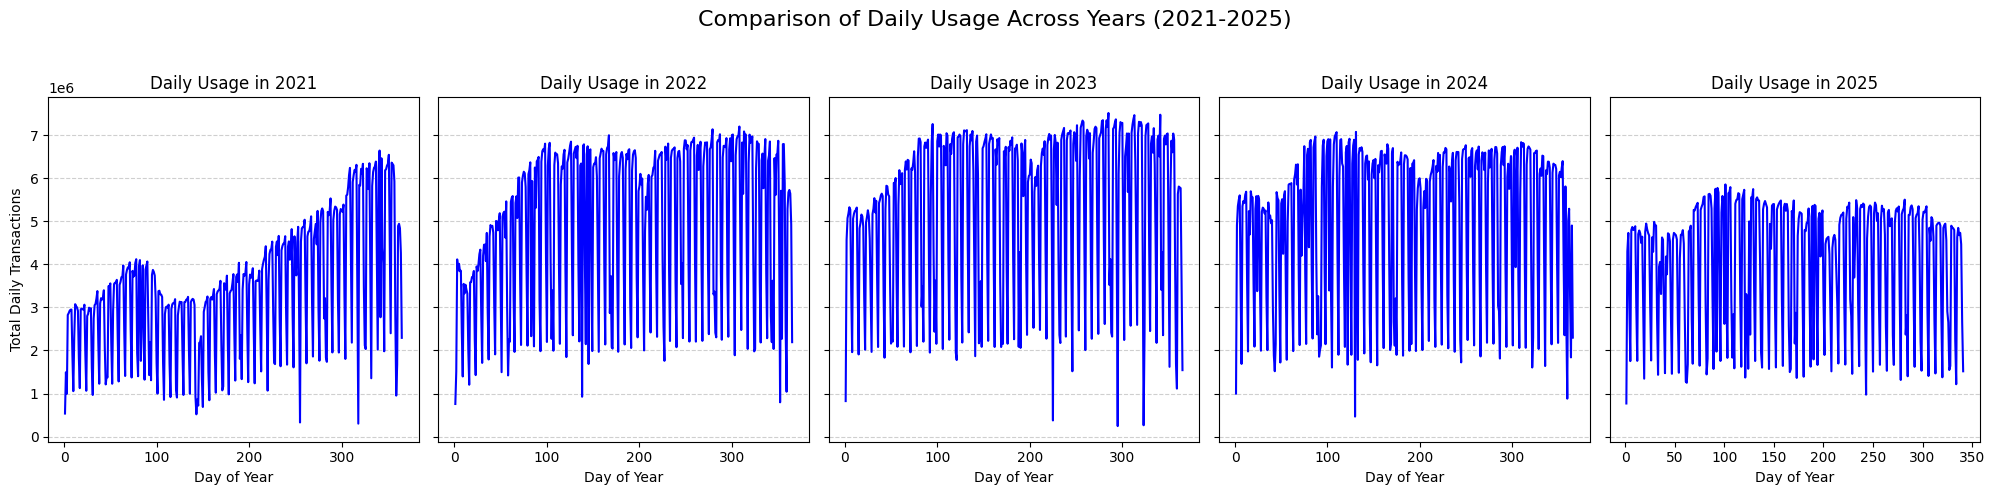

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

print("Generating Year-by-Year Time-Series Plots")

# 1. Aggregate the total daily usage
df_ts = df_caba.groupby('DIA_TRANSPORTE')['CANTIDAD'].sum().reset_index()

# 2. Extract the year from the date column
df_ts['Year'] = df_ts['DIA_TRANSPORTE'].dt.year
df_ts['DayOfYear'] = df_ts['DIA_TRANSPORTE'].dt.dayofyear # Used for plotting on a common axis

# 3. Get the list of unique years present in the data
years = sorted(df_ts['Year'].unique())

# 4. Create a figure with subplots (one row, multiple columns)
# Adjust figsize as needed based on the number of years.
fig, axes = plt.subplots(1, len(years), figsize=(4 * len(years), 5), sharey=True)
axes = axes.flatten() # Flattens the array of axes for easy indexing

for i, year in enumerate(years):
    # Filter the data for the current year
    df_year = df_ts[df_ts['Year'] == year]
    
    # Plot the daily usage against the day of the year (common X-axis)
    axes[i].plot(df_year['DayOfYear'], df_year['CANTIDAD'], label=str(year), color='b')
    
    axes[i].set_title(f'Daily Usage in {year}')
    axes[i].set_xlabel('Day of Year')
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

# Set the common Y-axis label
axes[0].set_ylabel('Total Daily Transactions')

plt.suptitle('Comparison of Daily Usage Across Years (2021-2025)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

## Identifying Top 5 Busiest Days in CABA

This analysis directly answers the Capacity and Efficiency question by finding the historical maximum demand days for the most critical area (CABA, including the consolidated 'JN' data).

## Let's plot

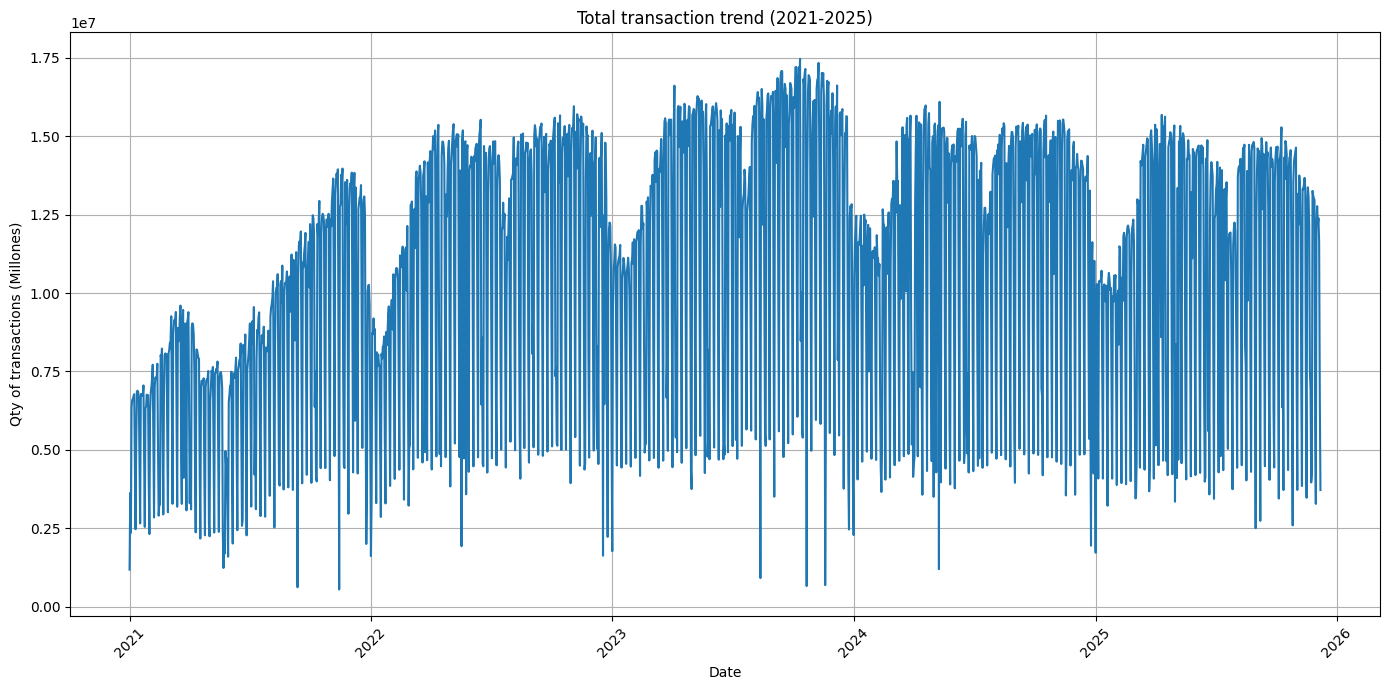

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by DIA_TRANSPORTE and CANTIDAD.
df_trend = df_analisis.groupby('DIA_TRANSPORTE')['CANTIDAD'].sum().reset_index()

# Rename Column (CANTIDAD is Daily Transactions)
df_trend.rename(columns={'CANTIDAD': 'CANTIDAD_TOTAL_DIARIA'}, inplace=True)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(df_trend['DIA_TRANSPORTE'], df_trend['CANTIDAD_TOTAL_DIARIA'], label='Total Daily Use')
plt.title('Total transaction trend (2021-2025)')
plt.xlabel('Date')
plt.ylabel('Qty of transactions (Millones)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Define the list of main transport types to include
main_transport_types = ['COLECTIVO', 'TREN', 'SUBTE']

